# Import

In [1]:
from pandas_data_reader_service_core.modules.finam.search_service import Search, Market
from pandas_data_reader_service_core.modules.finam.stock_info import FinamStockInfo
from pandas_data_reader_service_core.service import PandasDataReaderService as pdrs, StockInfo, TimeFrame
from datetime import date
import seaborn as sns
import pandas as pd
from typing import Tuple

# Build data

## Load data

In [2]:
eurusd_stock_list = Search.by_code("EURUSD", Market.CURRENCIES_WORLD)
eurusd_stock_list

,name,code,market
id,,,
83,Eur/Usd,EURUSD,5


In [3]:
eurusd_stock_info = StockInfo.init_for_Finam(FinamStockInfo(eurusd_stock_list.index[0]))
print(eurusd_stock_info)

Source StockSource.Finam source StockInfo Market 5 code EURUSD index 83


In [4]:
date_from = date(2015,1,1)
date_till = date(2020,2,1)
tf = TimeFrame.HOURLY

In [5]:
data_df = pdrs().get(stock=eurusd_stock_info,  date_from=date_from,date_to=date_till,time_frame=tf,short_col_name=True)
data_df

,O,H,L,C,V
DT,,,,,
2015-01-01 00:00:00,1.20986,1.21079,1.20970,1.21006,26264
2015-01-01 01:00:00,1.21005,1.21037,1.20960,1.21009,15605
2015-01-01 02:00:00,1.21016,1.21024,1.20950,1.21005,14092
2015-01-01 03:00:00,1.21003,1.21008,1.20948,1.20970,10195
2015-01-01 04:00:00,1.20971,1.21000,1.20948,1.20959,136
...,...,...,...,...,...
2020-01-31 21:00:00,1.10828,1.10836,1.10760,1.10799,69886
2020-01-31 22:00:00,1.10800,1.10902,1.10780,1.10894,78526
2020-01-31 23:00:00,1.10891,1.10919,1.10830,1.10904,56848


## Prepare data

### Column in rows

In [6]:
prepared_df = data_df.melt(id_vars=["V"], 
                            var_name="PT", 
                            value_name="PV")
len(prepared_df)

130744

In [7]:
prepared_df = prepared_df.groupby(["PT", "PV"]).sum().reset_index()
print(len(prepared_df))
prepared_df.head()

45788


,PT,PV,V
0,C,1.03558,108744
1,C,1.03696,101939
2,C,1.03713,102614
3,C,1.03739,142222
4,C,1.03766,107396


### Grouping

In [8]:
def split_into_group(from_v:float, till_v:float, group_count:int, round:int = 5)->Tuple[float, pd.DataFrame]:
    interval = (till_v - from_v)/group_count
    groups = []
    cur_gr_min = from_v
    cur_gr_max = cur_gr_min+interval
    idx = 1
    while idx < group_count:
        groups.append((cur_gr_min, cur_gr_max))
        cur_gr_min = cur_gr_max
        cur_gr_max = cur_gr_min+interval
        idx = idx + 1 
    groups.append((cur_gr_min, till_v))
    groups_df = pd.DataFrame(groups, columns =['From', 'Till'])
    groups_df["GR"] = groups_df.round(round)[["From","Till"]].apply(tuple,axis=1)
    return interval, groups_df

In [50]:
group_count = 500

In [51]:
min_pv = prepared_df["PV"].min()
max_pv = prepared_df["PV"].max()
interval, groups = split_into_group(min_pv, max_pv, group_count)
print(f'min = {min_pv}, max = {max_pv}, interval = {interval}')
groups["Intr"] = groups["Till"] - groups["From"]
groups

min = 1.03394, max = 1.25556, interval = 0.00044323999999999986


,From,Till,GR,Intr
0,1.033940,1.034383,"(1.03394, 1.03438)",0.000443
1,1.034383,1.034826,"(1.03438, 1.03483)",0.000443
2,1.034826,1.035270,"(1.03483, 1.03527)",0.000443
3,1.035270,1.035713,"(1.03527, 1.03571)",0.000443
4,1.035713,1.036156,"(1.03571, 1.03616)",0.000443
...,...,...,...,...
495,1.253344,1.253787,"(1.25334, 1.25379)",0.000443
496,1.253787,1.254230,"(1.25379, 1.25423)",0.000443
497,1.254230,1.254674,"(1.25423, 1.25467)",0.000443
498,1.254674,1.255117,"(1.25467, 1.25512)",0.000443


In [52]:
def pvg_factory(pv):
    find_groups = groups["GR"][groups["GR"].apply(lambda gr: pv > gr[0] and pv <= gr[1])]
    if len(find_groups) != 1:
        if pv == groups["GR"][0][0]:
            return 1
        raise Exception(f"Cann't define group for value {pv}, get {len(find_groups)} groups")
    try:
        return find_groups.index[0]+1
    except:
        raise Exception(f"Cann't define group for value {pv}, get {len(find_groups)} groups")

In [53]:
prepared_df["PVG"] = prepared_df["PV"].apply(lambda pv: pvg_factory(pv))
prepared_df

,PT,PV,V,PVG,PVGstr
0,C,1.03558,108744,4,1.03394-1.03616
1,C,1.03696,101939,7,1.03616-1.03837
2,C,1.03713,102614,8,1.03616-1.03837
3,C,1.03739,142222,8,1.03616-1.03837
4,C,1.03766,107396,9,1.03616-1.03837
...,...,...,...,...,...
45783,O,1.25380,49017,497,1.25334-1.25556
45784,O,1.25381,97892,497,1.25334-1.25556
45785,O,1.25392,94039,497,1.25334-1.25556
45786,O,1.25485,52679,499,1.25334-1.25556


### Define group volumes

In [54]:
grouped_df = prepared_df[["PVG","PT","V"]].groupby(["PT","PVG"]).sum().reset_index()
grouped_df

,PT,PVG,V
0,C,4,108744
1,C,7,101939
2,C,8,244836
3,C,9,184422
4,C,10,130003
...,...,...,...
1948,O,494,111512
1949,O,495,119963
1950,O,496,91835
1951,O,497,240948


# Analitic

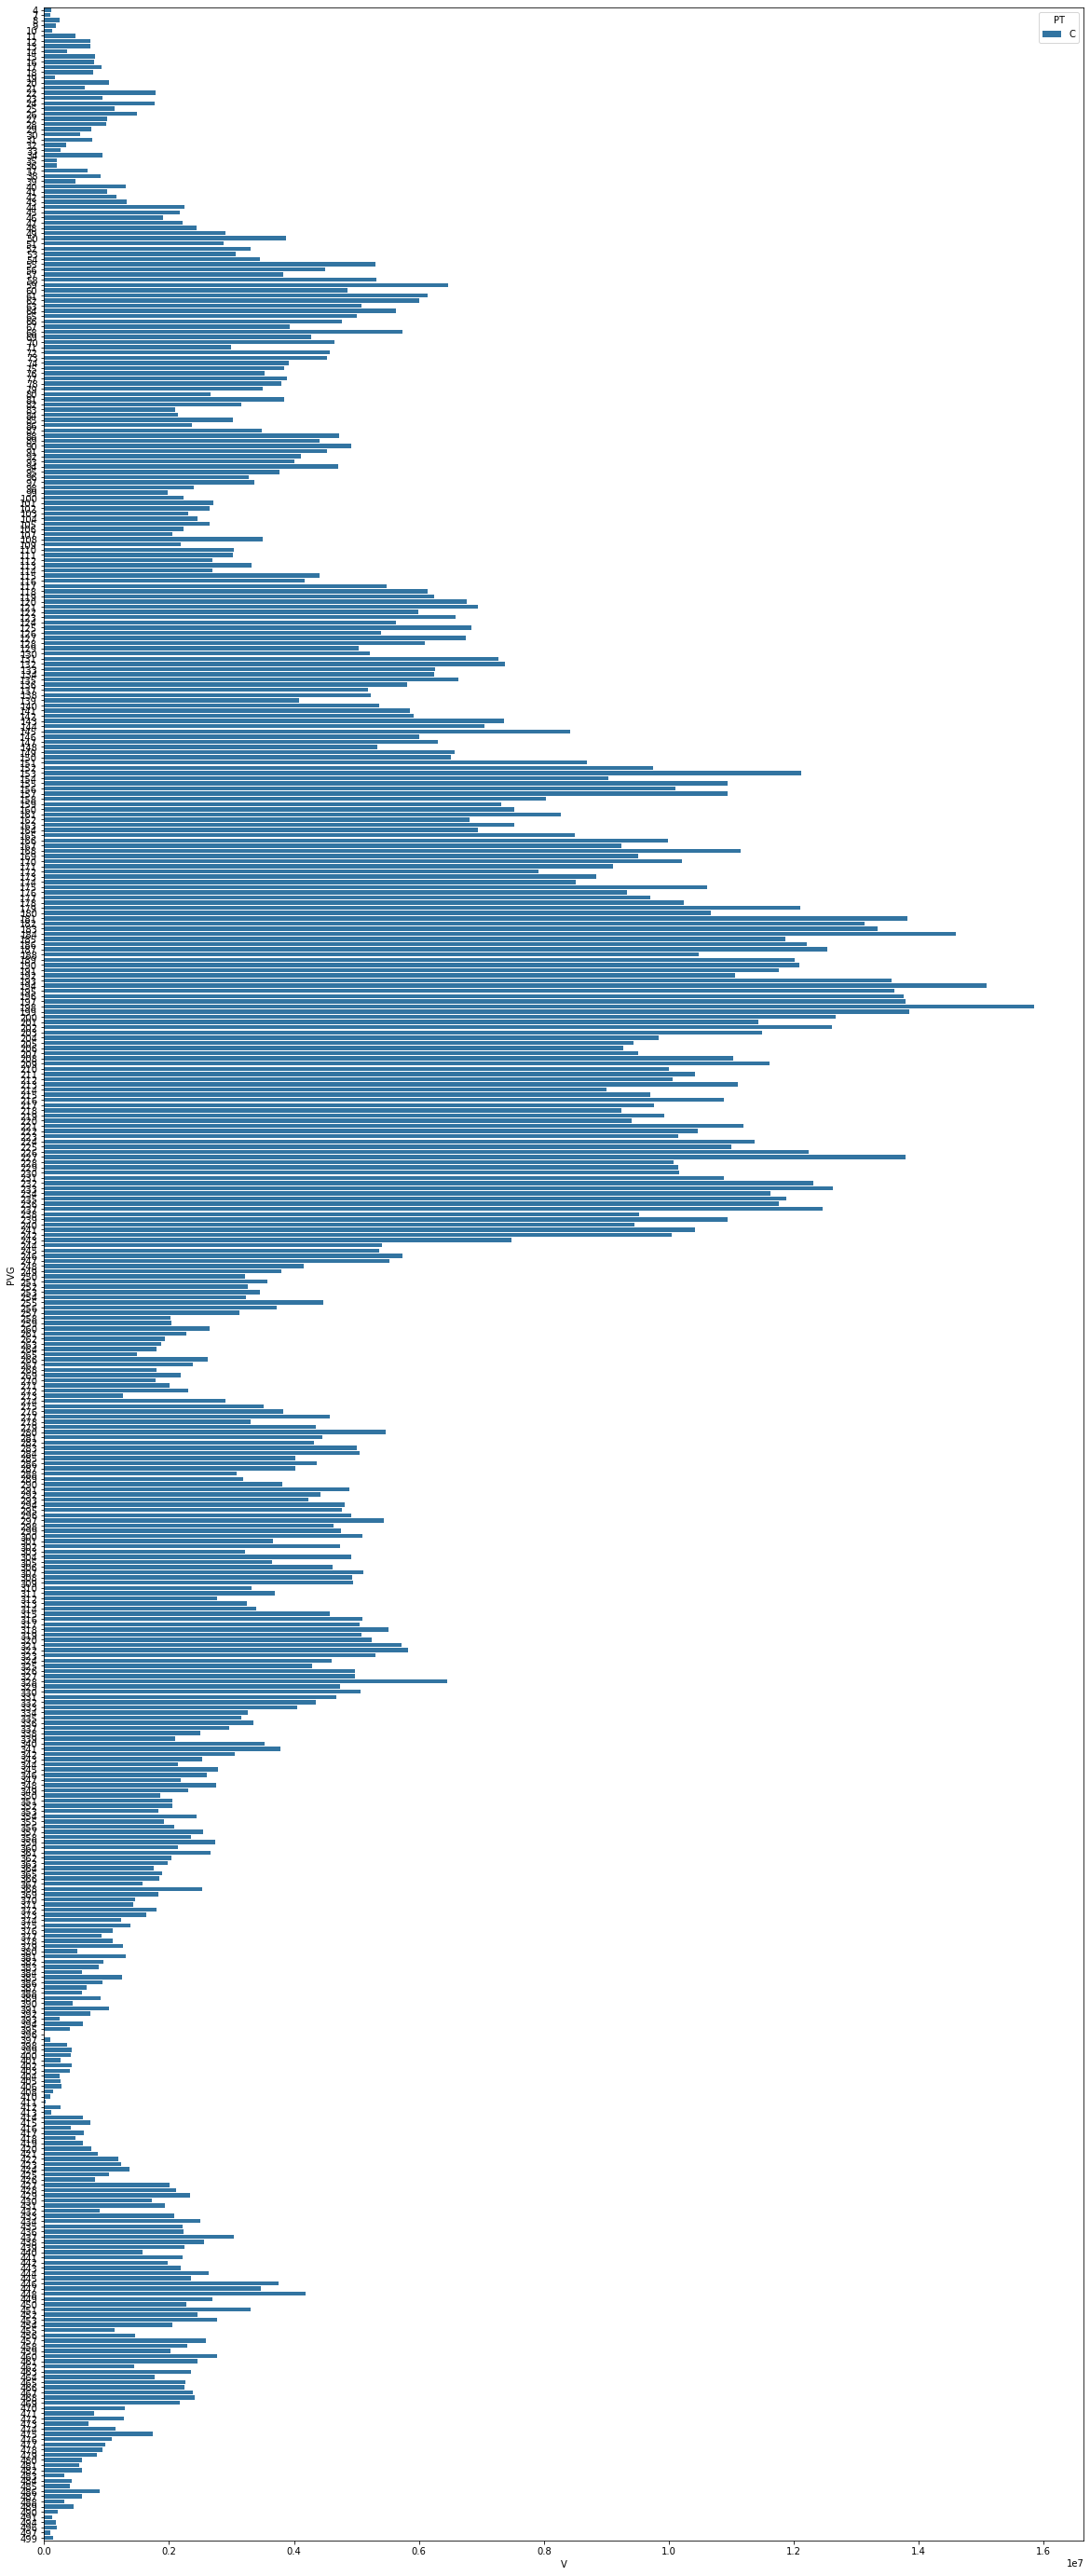

In [55]:
# Draw a nested barplot by species and sex
g = sns.barplot(
    data=grouped_df[grouped_df["PT"]=="C"], 
    x="V", y="PVG", hue="PT", orient = 'h'
)
g.figure.set_size_inches(20,50)